In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import os, sys
sys.path.append(os.path.abspath("../src"))

In [2]:
!pip install opencv-python

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from keras.layers import (
    Dense, Conv2D, Conv2DTranspose, Flatten, MaxPool2D, Reshape
)
from keras.models import Model, Input

Using TensorFlow backend.


In [4]:
import itertools as it
from keras.preprocessing.image import load_img
from PIL import Image

# Loading an preprocessing

In [5]:
def iterate_lfw(path):
    for root, _, files in os.walk(path):
        for file in files:
            if os.path.splitext(file)[-1] != ".jpg":
                continue
            yield os.path.join(root, file)
            
def load_and_preprocess(img_path):
    img = load_img(img_path)
    img = np.array(img)
    img = img[61:189, 61:189]
    img = Image.fromarray(img)
    return np.array(img.resize((64, 64)))



In [6]:
images = [
    load_and_preprocess(path)
    for path in it.islice(iterate_lfw("data/lfw-deepfunneled/"), 4096)
]

images = np.array(images)
np.random.shuffle(images)
images = (images.astype(np.float32) - 128.0) / 128

# Model

In [7]:
from keras.layers import LeakyReLU, BatchNormalization, GlobalAveragePooling2D, Flatten, Dropout
from keras.models import Sequential

In [8]:
def create_discriminator(input_dim):
    model = Sequential([
        Conv2D(32, (3,3), padding="same"),
        LeakyReLU(),
        Conv2D(32, (3,3), strides=2, padding="same"),
        LeakyReLU(),
        Conv2D(32, (3,3), padding="same"),
        LeakyReLU(),
        Conv2D(32, (3,3), strides=2, padding="same"),
        LeakyReLU(),
        Conv2D(32, (3,3), padding="same"),
        LeakyReLU(),
        Conv2D(32, (3,3), strides=4, padding="same"),
        LeakyReLU(),
        Flatten(),
        Dense(16),
        LeakyReLU(),
        Dense(1, activation="sigmoid")
    ])
    return model

def create_generator(noise_dim):
    model = Sequential([
        Dense(128, input_shape=(noise_dim,)),
        LeakyReLU(),
        Reshape((8, 8, 2)),
        Conv2DTranspose(32, (3, 3), strides=2, padding="same"),
        #BatchNormalization(),
        LeakyReLU(),
        Conv2D(32, (3, 3), padding="same"),
        LeakyReLU(),
        Conv2D(32, (3, 3), padding="same"),
        Dropout(0.4),
        LeakyReLU(),
        Conv2DTranspose(64, (3, 3), strides=2, padding="same"),
        #BatchNormalization(),
        LeakyReLU(),
        Conv2D(32, (3, 3), padding="same"),
        LeakyReLU(),
        Conv2D(32, (3, 3), padding="same"),
        Dropout(0.4),
        LeakyReLU(),
        Conv2DTranspose(32, (3, 3), strides=2, padding="same"),
        #BatchNormalization(),
        LeakyReLU(),
        Conv2D(64, (3, 3), padding="same"),
        LeakyReLU(),
        Conv2D(64, (3, 3), padding="same"),
        Dropout(0.4),
        LeakyReLU(),
        #BatchNormalization(),
        Conv2D(3, (5, 5), padding="same", activation="tanh")
    ])
    return model

In [9]:
from gan import GAN

In [10]:
gan = GAN(create_discriminator_func=create_discriminator,
          create_generator_func=create_generator,
          noise_dim=128,
          input_dim=(64,64,3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 2)           0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 32)        608       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 32)        0         
__________

0.3034159,0.9636599365621805, 1.0,0.494873046875
0.63775253,0.5972575764171779, 0.9536133,0.5
0.4615578,0.7332053538411856, 0.97302246,0.50048828125
0.62040365,0.5428806599229574, 0.85961914,0.5001220703125
0.6715282,0.45878808619454503, 0.6677246,0.504638671875


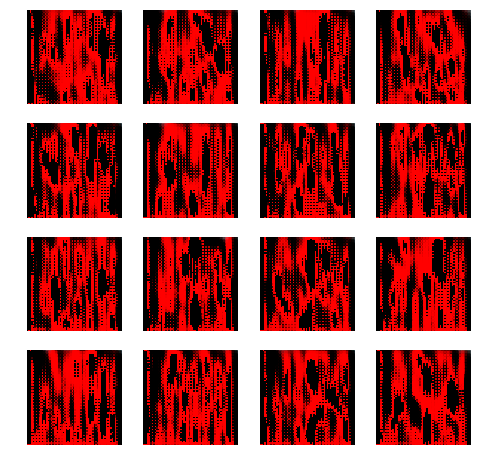

0.66302246,0.4324747980572283, 0.7998047,0.5003662109375
0.64219445,0.40768791176378727, 0.9350586,0.5003662109375
0.65548074,0.38769183214753866, 0.83361816,0.5303955078125
0.7293191,0.5410788115113974, 0.5633545,0.6224365234375
0.016421504,0.08533010388418916, 0.99975586,0.96728515625


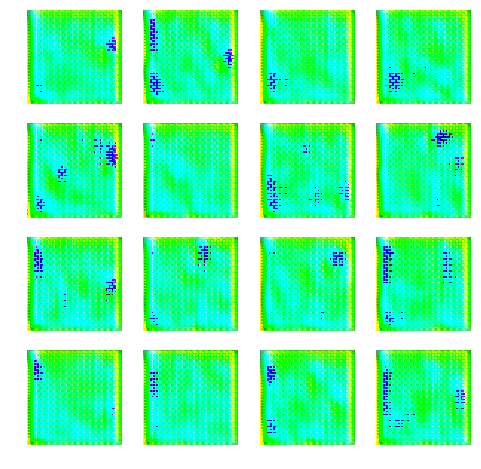

KeyboardInterrupt: 

In [11]:
noise = np.random.normal(size=(16,128))
for i in range(40):
    gan.train(images, 5, 128)
    pr = gan.generator.predict(noise)
    plt.figure(figsize=(8, 8))
    for j in range(16):
        plt.subplot(4, 4, j+1)
        plt.imshow(((pr[j] * 128) + 128).astype(np.uint8))
        plt.axis("off")
    plt.show()